데이터 및 분석에 필요한 모델들을 불러옵니다.


🏆 최종 DNN 모델 최적 임계값 적용: 0.52
분석 준비 완료.

📊 1. 최종 모델 (DNN) 성능 리포트
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

  잔존(Active)       0.91      0.81      0.86      1364
 이탈(Churned)       0.67      0.83      0.74       636

    accuracy                           0.82      2000
   macro avg       0.79      0.82      0.80      2000
weighted avg       0.83      0.82      0.82      2000



<Figure size 600x600 with 0 Axes>

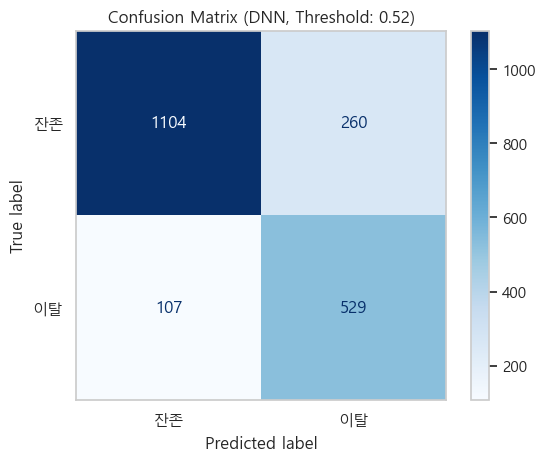

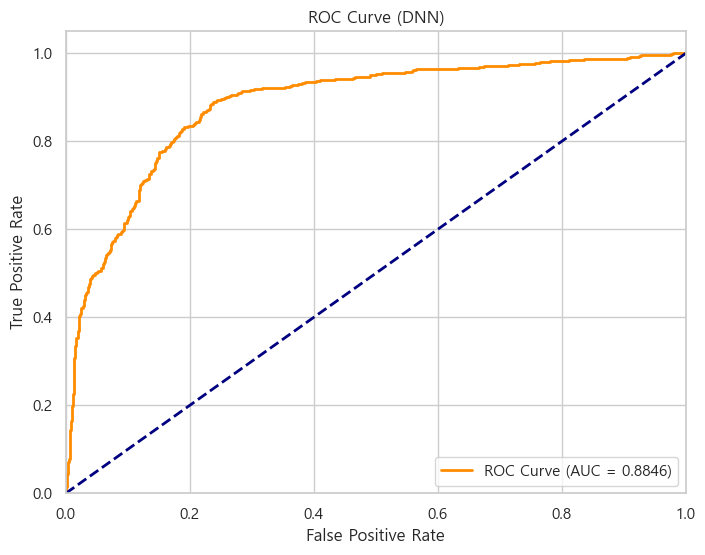

AUC 점수: 0.8846

📊 2. 특성 중요도 (Random Forest)
Permutation Importance 계산 중...


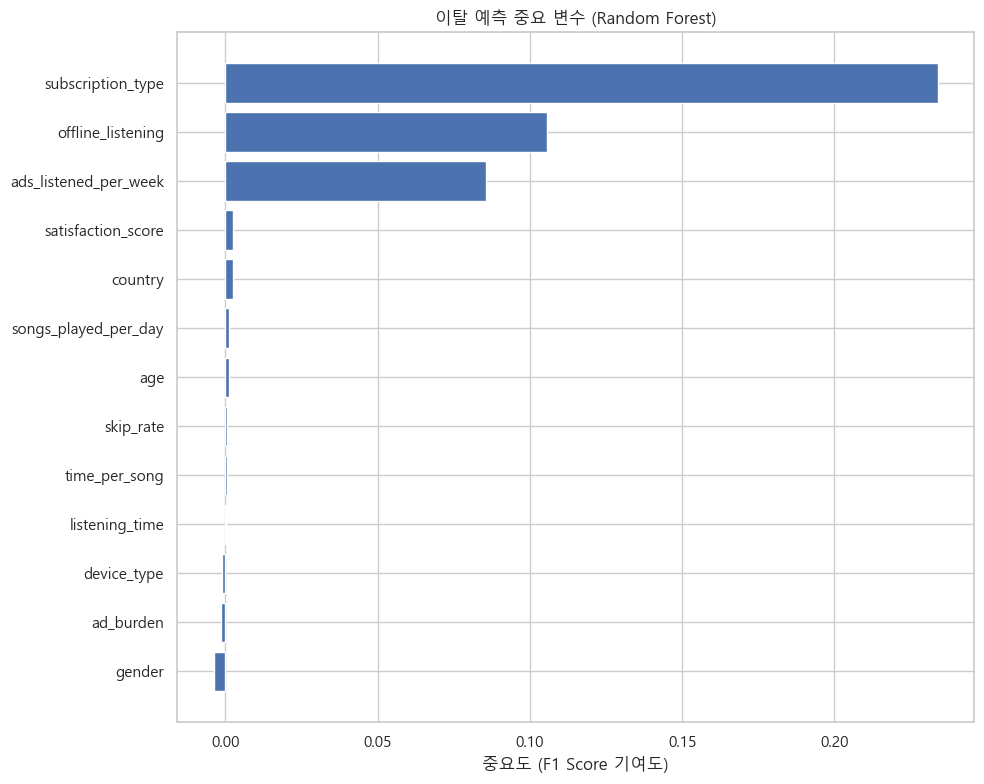


📊 3. Random Forest 모델 성능 참고 리포트
              precision    recall  f1-score   support

  잔존(Active)       0.93      0.77      0.84      1364
 이탈(Churned)       0.64      0.87      0.74       636

    accuracy                           0.80      2000
   macro avg       0.78      0.82      0.79      2000
weighted avg       0.84      0.80      0.81      2000


최종 분석 완료.


In [1]:
import pandas as pd
import numpy as np
import joblib
import json
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.inspection import permutation_importance
import sys # 오류 발생 시 프로그램 종료를 위해 import

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 시각화 스타일 설정 및 한글 폰트 지정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# 파일 경로 정의
DATA_PATH = '../data/spotify_churn_dataset.csv'
METRICS_PATH = '../data/model_metrics.json'
RF_MODEL_PATH = '../models/spotify_churn_model.pkl' # 특성 중요도 분석용 (Random Forest)
DL_MODEL_PATH = '../models/spotify_dl_model.h5' # 최종 성능 평가용 (DNN)
DL_PREPROCESSOR_PATH = '../models/dl_preprocessor.pkl' # DNN 전처리기

# 1. 데이터 및 모델 준비
print("데이터 및 분석에 필요한 모델들을 불러옵니다.")

# 데이터 로드
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    print(f"오류: 데이터 파일 {DATA_PATH}을 찾을 수 없습니다. 경로를 확인해주세요.")
    sys.exit(1)

# Feature Engineering (학습 때와 동일)
df['ad_burden'] = df['ads_listened_per_week'] / (df['listening_time'] + 1)
df['satisfaction_score'] = df['songs_played_per_day'] * (1 - df['skip_rate'])
df['time_per_song'] = df['listening_time'] / (df['songs_played_per_day'] + 1)

if 'user_id' in df.columns:
    df = df.drop(columns=['user_id'])

X = df.drop(columns=['is_churned'])
y = df['is_churned']

# 테스트 데이터 분리
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# 2. 모델 및 메트릭 로드
try:
    # 메트릭 로드 및 DNN 최적 임계값 확보
    with open(METRICS_PATH, 'r') as f:
        metrics = json.load(f)
    dnn_threshold = metrics.get('Deep Learning (DNN)', {}).get('Best Threshold', 0.5)
    
    # DNN 모델 및 전처리기 로드
    dl_model = tf.keras.models.load_model(DL_MODEL_PATH)
    dl_preprocessor = joblib.load(DL_PREPROCESSOR_PATH)
    
    # Random Forest 파이프라인 로드 (특성 중요도 분석용)
    rf_pipeline = joblib.load(RF_MODEL_PATH)
    
    print(f"🏆 최종 DNN 모델 최적 임계값 적용: {dnn_threshold:.2f}")
    print("분석 준비 완료.")
    
except Exception as e:
    print(f"오류: 모델 파일 또는 메트릭 로드 중 문제가 발생했습니다: {e}")
    sys.exit(1)


# --- 파트 1: DNN (최종 우승 모델) 성능 평가 ---

print("\n" + "="*50)
print("📊 1. 최종 모델 (DNN) 성능 리포트")
print("="*50)

# DNN 예측을 위한 데이터 전처리
X_test_scaled = dl_preprocessor.transform(X_test)
y_pred_proba_dnn = dl_model.predict(X_test_scaled).flatten()
y_pred_custom_dnn = (y_pred_proba_dnn >= dnn_threshold).astype(int)

# Classification Report 출력
print(classification_report(y_test, y_pred_custom_dnn, target_names=['잔존(Active)', '이탈(Churned)']))

# 혼동 행렬 시각화
cm_dnn = confusion_matrix(y_test, y_pred_custom_dnn)
disp_dnn = ConfusionMatrixDisplay(confusion_matrix=cm_dnn, display_labels=['잔존', '이탈'])
plt.figure(figsize=(6, 6))
disp_dnn.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (DNN, Threshold: {dnn_threshold:.2f})')
plt.grid(False)
plt.show() # 

# ROC Curve 및 AUC 계산/시각화
fpr_dnn, tpr_dnn, _ = roc_curve(y_test, y_pred_proba_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_dnn, tpr_dnn, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_dnn:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (DNN)')
plt.legend(loc="lower right")
plt.show() # 

print(f"AUC 점수: {roc_auc_dnn:.4f}")


# --- 파트 2: Random Forest (ML 모델) 특성 중요도 분석 ---

print("\n" + "="*50)
print("📊 2. 특성 중요도 (Random Forest)")
print("="*50)
print("Permutation Importance 계산 중...")

# Random Forest 모델을 사용해 특성 중요도 계산
result = permutation_importance(
    rf_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='f1')
sorted_idx = result.importances_mean.argsort()

# 특성 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("중요도 (F1 Score 기여도)")
plt.title("이탈 예측 중요 변수 (Random Forest)")
plt.tight_layout()
plt.show() # 

print("\n" + "="*50)
print("📊 3. Random Forest 모델 성능 참고 리포트")
print("="*50)

# Random Forest 성능 참고 (임계값 0.5 가정)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_custom_rf = (y_pred_proba_rf >= 0.5).astype(int)

print(classification_report(y_test, y_pred_custom_rf, target_names=['잔존(Active)', '이탈(Churned)']))
print("\n최종 분석 완료.")